# Generate forcing patterns
* plot coastline in POP only doesn't work for now

In [1]:
import os
from glob import glob
import random

import numpy as np
import xarray as xr
import pop_tools
import util

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.image import imread

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import cmocean
from sklearn.cluster import KMeans
from scipy.spatial import ConvexHull, Delaunay

## Get the POP grid data, and all kinds of masks

In [2]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
#grid, coast_indices = util.add_coast_mask(grid) # identify coastline indices in POP grid and add them to 

In [3]:
tlong = grid.TLONG.values
tlat = grid.TLAT.values
# #ocean_mask = xr.where(grid.KMT>0, 1, 0)

ocean_mask = (grid.KMT > 0).values # ocean mask as a numpy array
land_mask = (grid.KMT <= 0).values 
# coastal_mask = grid['coast_mask'].astype(np.int32)  # coastline mask, this is in the ocean, not on land
# region_mask_370km = xr.open_dataset('./pop_grid_eez.nc').eez_mask # EEZ mask, reading from a saved grid file
# open_ocean_mask = np.logical_not(region_mask_370km).astype(int)*ocean_mask  # excluding EEZ, just the open ocean
# ocean_mask = open_ocean_mask+region_mask_370km # ocean mask in xr.dataset, with TLONG and TLAT 

In [4]:
grid = xr.open_dataset('./pop_grid.nc')

FileNotFoundError: [Errno 2] No such file or directory: b'/glade/u/home/eyankovsky/CWorthy/pop_grid.nc'

# Figure 1. Forcing Pattern

In [ ]:
grid_name = 'POP_gx1v7'
grid = pop_tools.get_grid(grid_name)
tlong = grid.TLONG.values
tlat = grid.TLAT.values

In [ ]:
# pacific
final_polygon_mask = np.load('/glade/work/mengyangz/GVP/Pacific_final_polygon_mask.npy')
final_polygon_vertices = np.load('/glade/work/mengyangz/GVP/Pacific_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers = np.load('/glade/work/mengyangz/GVP/Pacific_final_cluster_centers.npy', allow_pickle=True)

In [ ]:
# atlantic
final_polygon_mask_atlantic = np.load('/glade/work/mengyangz/GVP/Atlantic_final_polygon_mask.npy')
final_polygon_vertices_atlantic = np.load('/glade/work/mengyangz/GVP/Atlantic_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_atlantic = np.load('/glade/work/mengyangz/GVP/Atlantic_final_cluster_centers.npy', allow_pickle=True)

In [ ]:
# south
final_polygon_mask_south = np.load('/glade/work/mengyangz/GVP/South_final_polygon_mask_120EEZ_180openocean.npy')
final_polygon_vertices_south = np.load('/glade/work/mengyangz/GVP/South_final_polygon_vertices_120EEZ_180openocean.npy', allow_pickle=True)
cluster_centers_south = np.load('/glade/work/mengyangz/GVP/South_final_cluster_centers_120EEZ_180openocean.npy', allow_pickle=True)

In [ ]:
# southern ocean
final_polygon_mask_SO = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_polygon_mask.npy')
final_polygon_vertices_SO = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_polygon_vertices.npy', allow_pickle=True)
cluster_centers_SO = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_cluster_centers.npy', allow_pickle=True)

In [ ]:
%%time
fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=240))
ax.set_extent([95, 390, -20, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(final_polygon_mask_atlantic)):
    vertices = np.array(final_polygon_vertices_atlantic[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
    
for i in range(len(final_polygon_mask)):
    vertices = np.array(final_polygon_vertices[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    ax.text(cluster_centers[i, 0]-2, cluster_centers[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())


#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

ax.set_xticks(np.arange(100, 390, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-10, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)

#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/Forcing_pattern_together.png', dpi=400, bbox_inches='tight')

In [ ]:
final_polygon_mask_SO.shape

In [ ]:
%%time
plt.rcParams.update({'font.size': 24})
fig = plt.figure(figsize=(16,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=208))
ax.set_extent([0, 360, -90, 80], crs=ccrs.PlateCarree())
ax.tick_params(axis='both', labelsize=24)
ax.imshow(imread('./lightearth.jpg'),origin='upper', transform=ccrs.PlateCarree(), extent=[-180, 180, -90, 90])
#ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

def plot_polygons(final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic, offset=0):
    for i in range(len(final_polygon_mask_atlantic)):
        vertices = np.array(final_polygon_vertices_atlantic[i])
        # plot convex hull
        if len(vertices) >= 3:
            hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
            polygon = list(vertices[i] for i in hull.vertices.tolist() )
            polygon = np.array(polygon)

            ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())

        # plot polygon masks
        index = np.where(final_polygon_mask_atlantic[i] == 1)
        ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
        ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1, str(i+offset), fontsize=7, color='k', transform=ccrs.PlateCarree())

plot_polygons(final_polygon_mask_atlantic, final_polygon_vertices_atlantic, cluster_centers_atlantic)
plot_polygons(final_polygon_mask,final_polygon_vertices, cluster_centers, offset=150)
plot_polygons(final_polygon_mask_south, final_polygon_vertices_south, cluster_centers_south, offset=150+200)
plot_polygons(final_polygon_mask_SO, final_polygon_vertices_SO, cluster_centers_SO, offset=150+200+300)

ax.set_xticks(np.arange(10, 400, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-60, 100, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)
#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/figures/Global_Forcing_reindex.png', dpi=400, bbox_inches='tight')

Add area distributions

In [13]:
def get_area_from_mask(mask_atl, centers_atl):
    
    mask_atl = xr.DataArray(mask_atl, dims=('region', 'nlat', 'nlon'), coords={'region': np.arange(0,mask_atl.shape[0])})
    #mask_atl.attrs['mask_name'] = 'North_Atlantic_basin'
    area_atl = mask_atl*grid.TAREA/(1e10) # km^2
    
    # sum of all areas
    area_atl_sum = area_atl.sum(dim={'nlat', 'nlon'}) 
    # number of grid points
    count_num = area_atl.where(area_atl != 0).count(dim={'nlat', 'nlon'})
    
    return area_atl_sum, count_num

In [14]:
mask_atl = np.load('/glade/work/mengyangz/GVP/Atlantic_final_polygon_mask.npy')
mask_pac = np.load('/glade/work/mengyangz/GVP/Pacific_final_polygon_mask.npy')
mask_south = np.load('/glade/work/mengyangz/GVP/South_final_polygon_mask_120EEZ_180openocean.npy')
mask_SO = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_polygon_mask.npy')

centers_atl = np.load('/glade/work/mengyangz/GVP/Atlantic_final_cluster_centers.npy',allow_pickle=True)
centers_pac = np.load('/glade/work/mengyangz/GVP/Pacific_final_cluster_centers.npy',allow_pickle=True)
centers_south = np.load('/glade/work/mengyangz/GVP/South_final_cluster_centers_120EEZ_180openocean.npy',allow_pickle=True)
centers_SO = np.load('/glade/work/mengyangz/GVP/Southern_Ocean_final_cluster_centers.npy',allow_pickle=True)

area_atl, count_atl = get_area_from_mask(mask_atl, centers_atl)
area_pac, count_pac = get_area_from_mask(mask_pac, centers_pac)
area_south, count_south = get_area_from_mask(mask_south, centers_south)
area_SO, count_SO = get_area_from_mask(mask_SO, centers_SO)

In [15]:
area_SO.shape

(40,)

In [16]:
area_EEZ = np.concatenate((area_atl[:100].values, area_pac[:90].values, area_south[:120].values))
area_open_ocean = np.concatenate((area_atl[100:].values, area_pac[90:].values, area_south[120:].values, area_SO.values))

center_EEZ = np.concatenate((centers_atl[:100], centers_pac[:90], centers_south[:120]))
center_open_ocean = np.concatenate((centers_atl[100:], centers_pac[90:], centers_south[120:], centers_SO))

count_EEZ = np.concatenate((count_atl[:100], count_pac[:90], count_south[:120]))
count_open_ocean = np.concatenate((count_atl[100:], count_pac[90:], count_south[120:], count_SO))

In [17]:
area_EEZ.shape, area_open_ocean.shape

((310,), (380,))

In [18]:
np.mean(area_EEZ), np.std(area_EEZ) 

(227495.66454189137, 65941.21011644701)

In [19]:
np.mean(area_open_ocean), np.std(area_open_ocean) 

(720741.5820363249, 167776.22739579616)

a percentage variation in area relative to the median or mean patch area

In [20]:
np.median(area_EEZ), np.median(area_open_ocean)

(236907.68424204914, 718385.8525055319)

In [21]:
median_value = np.median(area_EEZ)
percentage_variations = [(value - median_value) / median_value * 100 for value in area_EEZ]
percentage_variations = np.array(percentage_variations)
print(f'Median values: {median_value}; variation ranges from {percentage_variations.min()} to {percentage_variations.max()}')

Median values: 236907.68424204914; variation ranges from -77.49827675951867 to 79.5488210561798


In [22]:
median_value = np.median(area_open_ocean)
percentage_variations = [(value - median_value) / median_value * 100 for value in area_open_ocean]
percentage_variations = np.array(percentage_variations)
print(f'Median values: {median_value}; variation ranges from {percentage_variations.min()} to {percentage_variations.max()}')

Median values: 718385.8525055319; variation ranges from -86.1659013050426 to 57.34638046724171


In [24]:
import numpy as np

def calculate_percentage_variation(data):
    # Step 1: Calculate the Median
    median_value = np.median(data)

    # Step 2: Calculate Percentage Variation for each value
    percentage_variations = [(value - median_value) / median_value * 100 for value in data]

    # Step 3: Report the Results
    return median_value, percentage_variations

# Example Usage
data = [10, 15, 20, 25, 30]
percentage_variations = calculate_percentage_variation(data)

# # Display the Results
# for value, percentage_variation in zip(data, percentage_variations):
#     print(f"Value: {value}, Percentage Variation: {percentage_variation:.2f}%")


Text(-300000.0, 129, 'b')

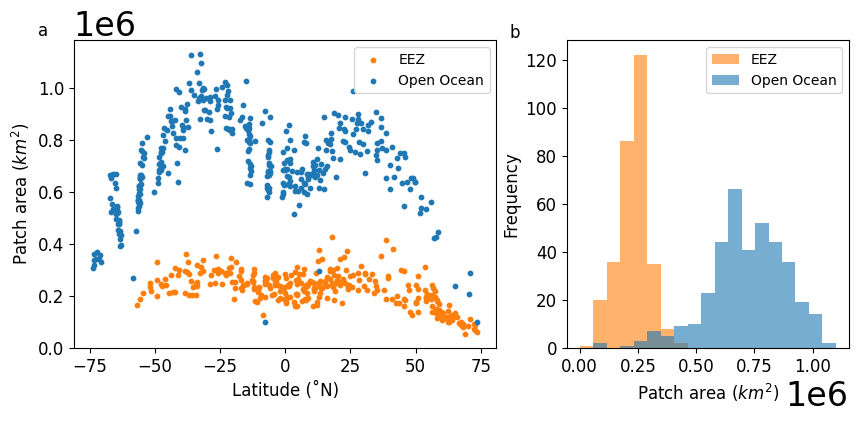

In [27]:
fig = plt.figure(figsize=(10,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1.5, 1])  # Adjust the width ratios as needed

ax = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# histogram
bins=np.linspace(0, 1.1e6, 20)
ax1.hist(area_EEZ, bins=bins, alpha=0.6, label='EEZ', color='C1')
ax1.hist(area_open_ocean, bins=bins, alpha=0.6, label='Open Ocean', color='C0')

# scatter
ax.scatter(center_EEZ[:, 1], area_EEZ, s=10, marker='o', facecolors='C1', edgecolors='C1', label='EEZ')
ax.scatter(center_open_ocean[:, 1], area_open_ocean, s=10, marker='o', facecolors='C0', edgecolors='C0', label='Open Ocean')

FONTSIZE=12
ax.set_xlabel('Latitude (˚N)', fontsize=FONTSIZE)      
ax.set_ylabel('Patch area ($km^2$)', fontsize=FONTSIZE)      

ax1.set_xlabel('Patch area ($km^2$)', fontsize=FONTSIZE)      
ax1.set_ylabel('Frequency', fontsize=FONTSIZE)      

def modify(ax):
    ax.tick_params(axis='x', labelsize=FONTSIZE)
    ax.tick_params(axis='y', labelsize=FONTSIZE)
    
modify(ax)
modify(ax1)

ax.legend(fontsize=FONTSIZE-2)               
ax1.legend(fontsize=FONTSIZE-2)    

ax.text(-95, 1.2e6, 'a', fontsize=FONTSIZE)
ax1.text(-0.3e6, 129, 'b', fontsize=FONTSIZE)

#plt.savefig('./figures/manuscript_area_distribution.png', dpi=200, bbox_inches='tight')

CPU times: user 1.8 s, sys: 27 ms, total: 1.83 s
Wall time: 1.83 s


Text(-300000.0, 129, '(b)')

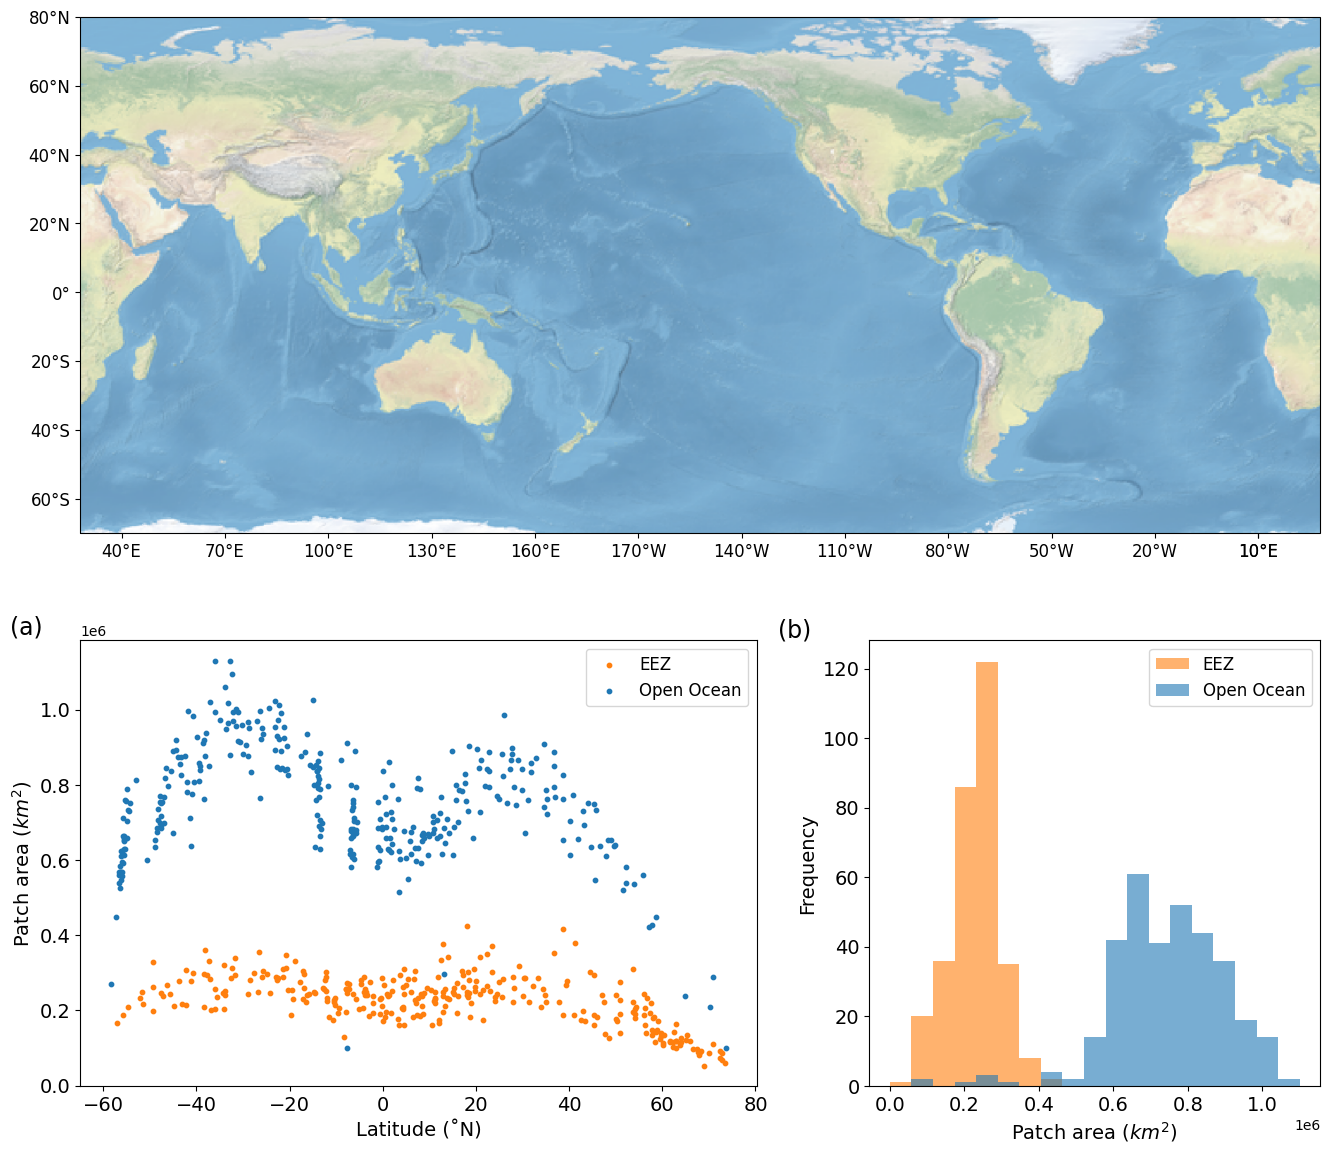

In [29]:
%%time
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

FONTSIZE=14
# Create a 2x1 grid
outer_grid = gridspec.GridSpec(2, 1, height_ratios=[1.2, 1])
# Set the figure size
fig = plt.figure(figsize=(16, 14))
ax = plt.subplot(outer_grid[0], projection=ccrs.PlateCarree(central_longitude=208))

# Create an inner grid for the second row
inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[1], width_ratios=[1.5, 1])
ax2 = plt.subplot(inner_grid[0])
ax3 = plt.subplot(inner_grid[1])

########## map
ax.set_extent([0, 360, -70, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

# for i in range(len(final_polygon_mask_atlantic)):
#     vertices = np.array(final_polygon_vertices_atlantic[i])
#     # plot convex hull
#     if len(vertices) >= 3:
#         hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
#         polygon = list(vertices[i] for i in hull.vertices.tolist() )
#         polygon = np.array(polygon)

#         ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
#     # plot polygon masks
#     index = np.where(final_polygon_mask_atlantic[i] == 1)
#     ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
#     #ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
    
# for i in range(len(final_polygon_mask)):
#     vertices = np.array(final_polygon_vertices[i])
#     # plot convex hull
#     if len(vertices) >= 3:
#         hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
#         polygon = list(vertices[i] for i in hull.vertices.tolist() )
#         polygon = np.array(polygon)

#         ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
#     # plot polygon masks
#     index = np.where(final_polygon_mask[i] == 1)
#     ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
#     #ax.text(cluster_centers[i, 0]-2, cluster_centers[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
    
# for i in range(len(final_polygon_mask_south)):
#     vertices = np.array(final_polygon_vertices_south[i])
#     # plot convex hull
#     if len(vertices) >= 3:
#         hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
#         polygon = list(vertices[i] for i in hull.vertices.tolist() )
#         polygon = np.array(polygon)

#         ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
#     # plot polygon masks
#     index = np.where(final_polygon_mask_south[i] == 1)
#     ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
#     #ax.text(cluster_centers_south[i, 0]-2, cluster_centers_south[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())


#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

ax.set_xticks(np.arange(10, 400, 30), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-60, 100, 20), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)

########## hist
# histogram
bins=np.linspace(0, 1.1e6, 20)
ax3.hist(area_EEZ, bins=bins, alpha=0.6, label='EEZ', color='C1')
ax3.hist(area_open_ocean, bins=bins, alpha=0.6, label='Open Ocean', color='C0')

# scatter
ax2.scatter(center_EEZ[:, 1], area_EEZ, s=10, marker='o', facecolors='C1', edgecolors='C1', label='EEZ')
ax2.scatter(center_open_ocean[:, 1], area_open_ocean, s=10, marker='o', facecolors='C0', edgecolors='C0', label='Open Ocean')

ax2.set_xlabel('Latitude (˚N)', fontsize=FONTSIZE)      
ax2.set_ylabel('Patch area ($km^2$)', fontsize=FONTSIZE)      

ax3.set_xlabel('Patch area ($km^2$)', fontsize=FONTSIZE)      
ax3.set_ylabel('Frequency', fontsize=FONTSIZE)      

def modify(ax):
    ax.tick_params(axis='x', labelsize=FONTSIZE)
    ax.tick_params(axis='y', labelsize=FONTSIZE)
    
modify(ax2)
modify(ax3)

ax2.legend(fontsize=FONTSIZE-2)               
ax3.legend(fontsize=FONTSIZE-2)    

ax2.text(-80, 1.2e6, '(a)', fontsize=FONTSIZE+3)
ax3.text(-0.3e6, 129, '(b)', fontsize=FONTSIZE+3)

#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/figures/Global_Forcing_south_120EEZ_180openocean_no_text.png', dpi=400, bbox_inches='tight')

CPU times: user 4.91 s, sys: 32.1 ms, total: 4.94 s
Wall time: 5.01 s


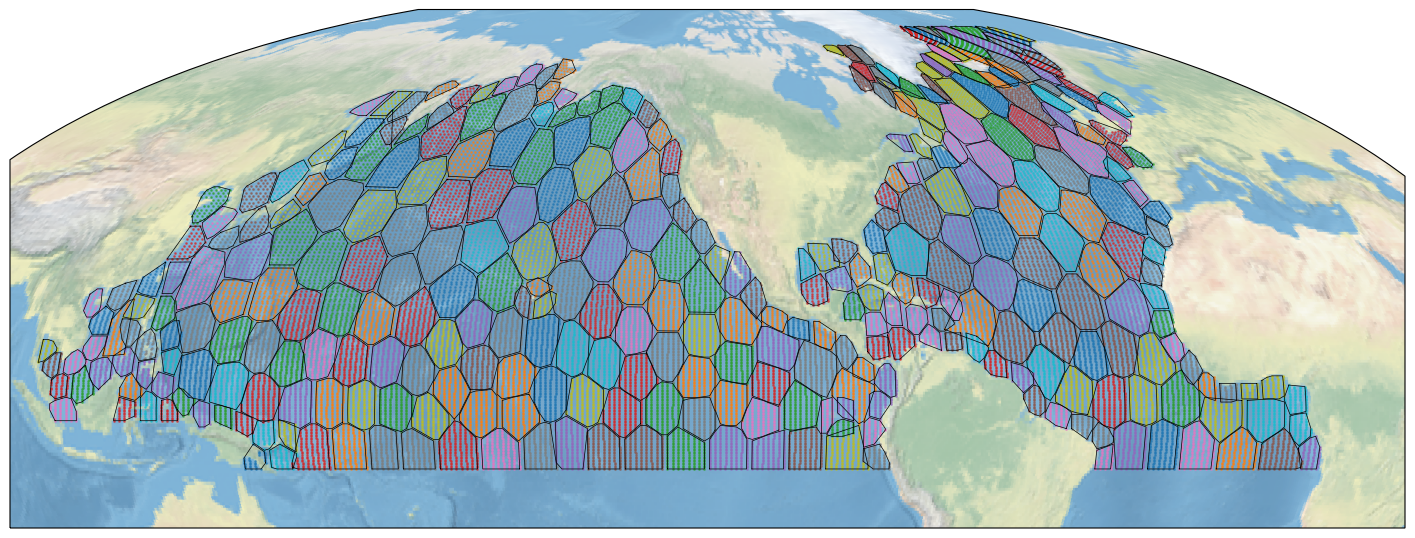

In [13]:
%%time
fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude=240))
ax.set_extent([95, 390, -20, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(final_polygon_mask_atlantic)):
    vertices = np.array(final_polygon_vertices_atlantic[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
    
for i in range(len(final_polygon_mask)):
    vertices = np.array(final_polygon_vertices[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers[i, 0]-2, cluster_centers[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())


#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

# ax.set_xticks(np.arange(100, 390, 20), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(-10, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)

#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/Forcing_pattern_together.png', dpi=400, bbox_inches='tight')

CPU times: user 3.48 s, sys: 3.96 ms, total: 3.48 s
Wall time: 3.55 s


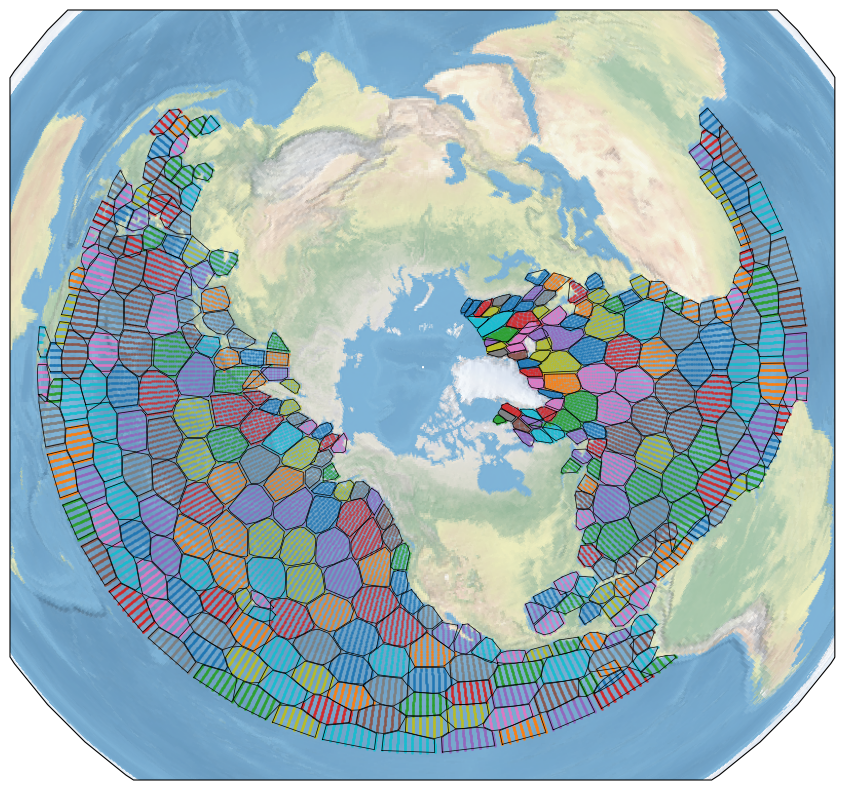

In [14]:
%%time
fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertAzimuthalEqualArea(central_longitude=240, central_latitude=90))
ax.set_extent([95, 390, -20, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(final_polygon_mask_atlantic)):
    vertices = np.array(final_polygon_vertices_atlantic[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
    
for i in range(len(final_polygon_mask)):
    vertices = np.array(final_polygon_vertices[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers[i, 0]-2, cluster_centers[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())


#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

# ax.set_xticks(np.arange(100, 390, 20), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(-10, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)

#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/Forcing_pattern_together.png', dpi=400, bbox_inches='tight')

In [38]:
import math
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting toolkit

def spherical_to_cartesian(tlat, tlong, radius):

    '''
    tlat, tlong are arrays,
    radius: Earth's average radius in km
    '''
    
    x = np.zeros_like(tlong)
    y = np.zeros_like(tlong)
    z = np.zeros_like(tlong)
    
    if tlong.ndim == 2:
        for i in range(tlong.shape[0]):
            for j in range(tlong.shape[1]):

                latitude = math.radians(tlat[i,j])
                longitude = math.radians(tlong[i,j])
                x[i,j] = radius * math.cos(latitude) * math.cos(longitude)
                y[i,j] = radius * math.cos(latitude) * math.sin(longitude)
                z[i,j] = radius * math.sin(latitude)
        
    elif tlong.ndim == 1:
        for i in range(tlong.shape[0]):
            
                latitude = math.radians(tlat[i])
                longitude = math.radians(tlong[i])
                x[i] = radius * math.cos(latitude) * math.cos(longitude)
                y[i] = radius * math.cos(latitude) * math.sin(longitude)
                z[i] = radius * math.sin(latitude)

    return x, y, z

In [54]:
radius = 6371
tlong = grid.TLONG.values
tlat = grid.TLAT.values
x_all, y_all, z_all = spherical_to_cartesian(tlat, tlong, radius)

In [174]:
def plot_3d_pattern(i_az, az, elev, atl=True, pac=True, save=False, close=True):

    random.seed(4)
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(15,13))
    ax = fig.add_subplot(111, projection='3d')
    
    # coastline
    ax.scatter((x_all*ocean_mask)[coast_indices], (y_all*ocean_mask)[coast_indices], (z_all*ocean_mask)[coast_indices], s=1, c='gray', alpha=0.3)


    # a list of colors
    colors = list(mcolors.TABLEAU_COLORS.values())
    ind_color = np.arange(len(colors)) # 0- 9
    
    if atl==True:  # plot Atlantic

        for i in range(len(final_polygon_mask_atlantic)):
            vertices = np.array(final_polygon_vertices_atlantic[i])

            # plot polygon masks
            index = np.where(final_polygon_mask_atlantic[i] == 1)
            x, y, z = spherical_to_cartesian(tlat[index], tlong[index], radius)
            ax.scatter(x, y, z, c=colors[random.choice(ind_color)], s=1, alpha=0.8)
            #ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
            
            # plot convex hull
            if len(vertices) >= 3:
                hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
                polygon = list(vertices[i] for i in hull.vertices.tolist() )
                polygon = np.array(polygon)


                x, y, z = spherical_to_cartesian(np.append(polygon[:,1], polygon[0,1]), np.append(polygon[:,0], polygon[0,0]), radius)
                ax.plot(x, y, z, 'k-', linewidth=1.5)



    if pac==True:  # plot Pacific
        for i in range(len(final_polygon_mask)):
            vertices = np.array(final_polygon_vertices[i])

            # plot polygon masks
            index = np.where(final_polygon_mask[i] == 1)
            x, y, z = spherical_to_cartesian(tlat[index], tlong[index], radius)
            ax.scatter(x, y, z, c=colors[random.choice(ind_color)], s=0.8, alpha=0.8)
            #ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
            
            # plot convex hull
            if len(vertices) >= 3:
                hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
                polygon = list(vertices[i] for i in hull.vertices.tolist() )
                polygon = np.array(polygon)

                x, y, z = spherical_to_cartesian(np.append(polygon[:,1], polygon[0,1]), np.append(polygon[:,0], polygon[0,0]), radius)
                ax.plot(x, y, z, 'k-', linewidth=1.5)
   
    #ax.scatter(x_all*land_mask, y_all*land_mask, z_all*land_mask, s=2, c=z_all*land_mask, alpha=0.15, cmap='Greys')
    #ax.scatter(x_all*land_mask, y_all*land_mask, z_all*land_mask, s=2,  alpha=0.05, c='gray')
    #ax.scatter(x*mask_atlantic, y*mask_atlantic, z*mask_atlantic, s=2, c='b', alpha=0.1)
    #ax.scatter(x*mask_pacific, y*mask_pacific, z*mask_pacific, s=2, c='g', alpha=1)


    # Set labels for the axes
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    ax.set_zlabel('Z (km)')

    azim=az[i_az]
    ax.view_init(elev=elev, azim=azim)  # Change the elevation and azimuth angles

    if save == True:
        fig.savefig(f'/glade/work/mengyangz/GVP/Manuscript/figs2movie/azim_{i_az:03d}.png', dpi=200, bbox_inches='tight')
        
    if close == True:
        plt.close()

In [170]:
# angles to rotate, 
az1 = np.arange(-30, -90, -2)  # az1 is when to show Atlantic
az2 = np.arange(-90, -220, -2) # show Pacific

az = np.concatenate([az1,az2])

In [ ]:
ffmpeg -framerate 5 -pattern_type glob -i '*.png' -vf scale=3274:-2 -c:v libx264 -pix_fmt yuv420p north_is_smaller.mp4

In [ ]:
for i in range(1, az.size):
    if az[i] >= -90:
        plot_3d_pattern(i, az, elev=30, atl=True, pac=False, save=True, close = True)
    else: 
        plot_3d_pattern(i, az, elev=30, atl=False, pac=True, save=True, close = True)

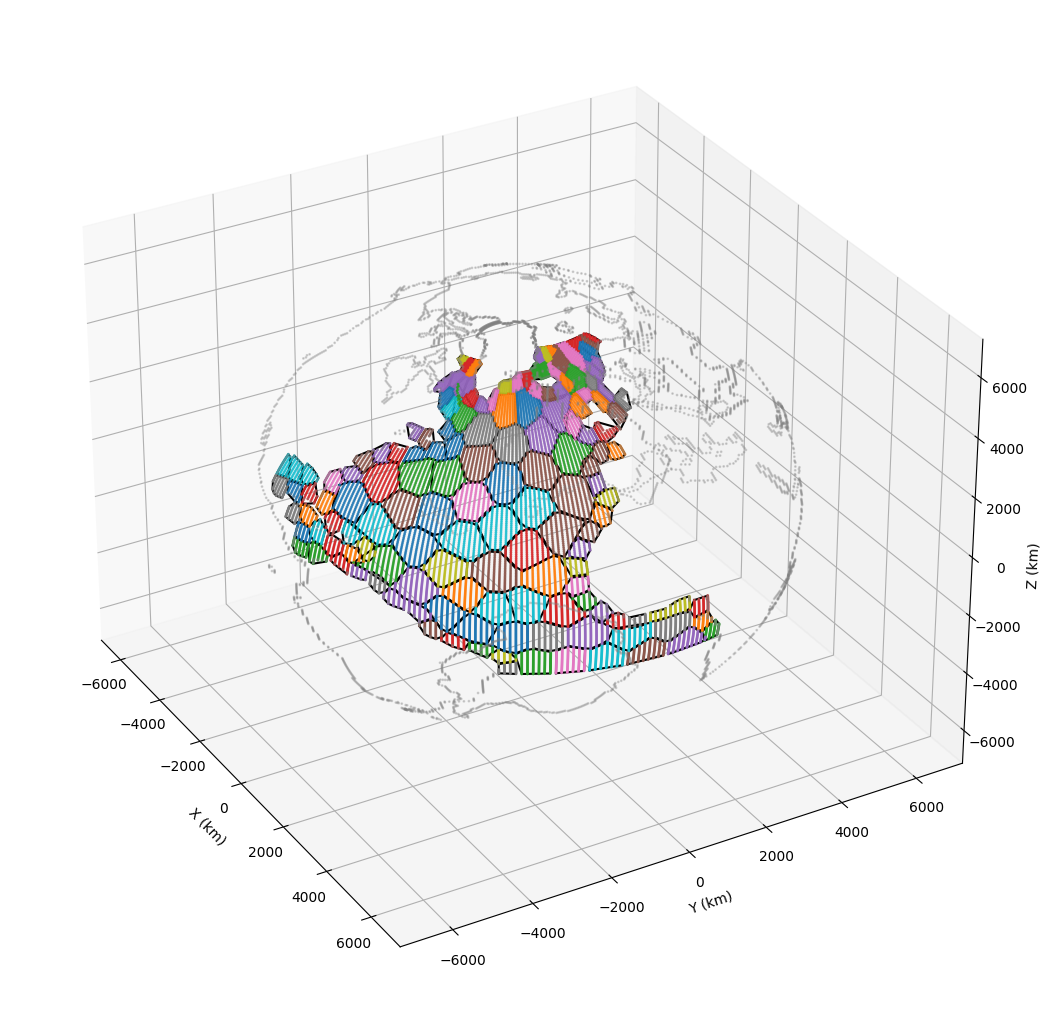

In [140]:
plot_3d_pattern(elev=30, azim = -30, atl=True, pac=False, save=False, close =False)

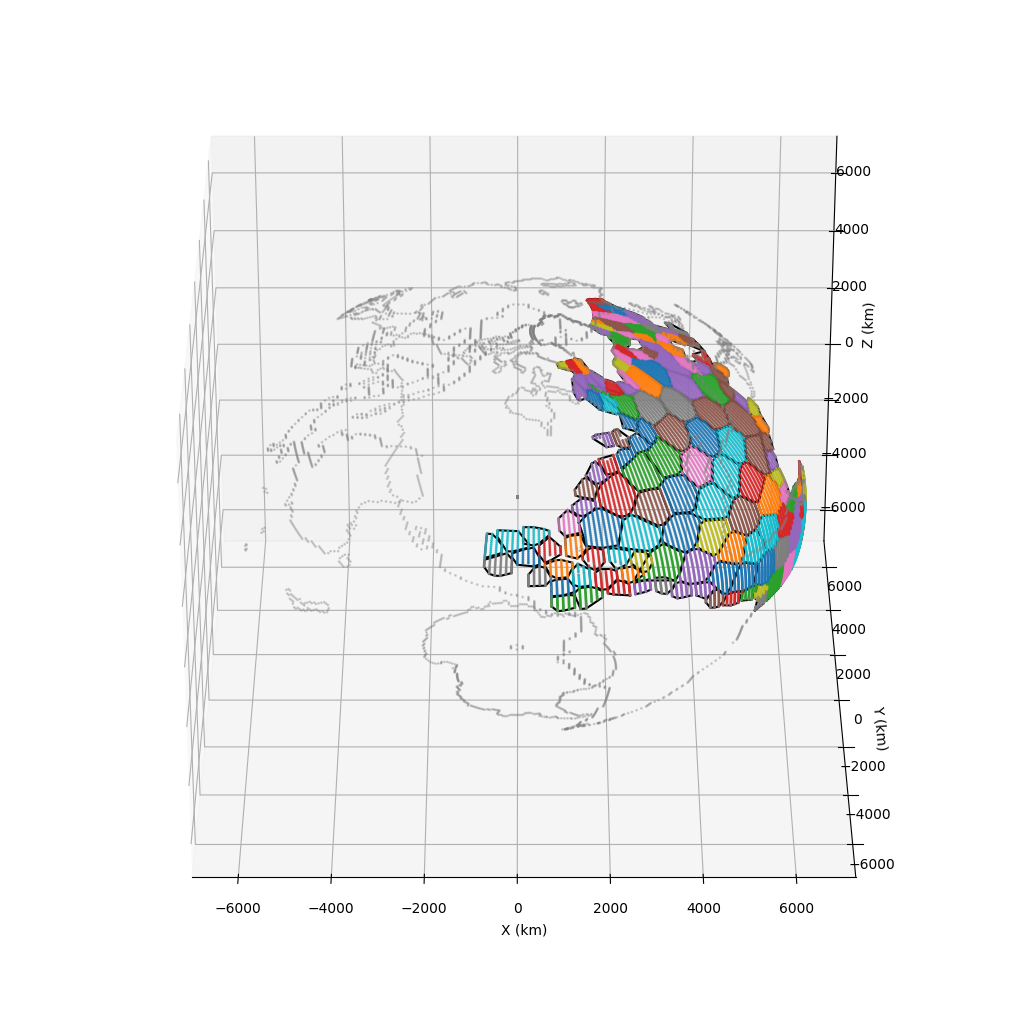

In [145]:
plot_3d_pattern(elev=30, azim = -90, atl=True, pac=False, save=False, close =False)

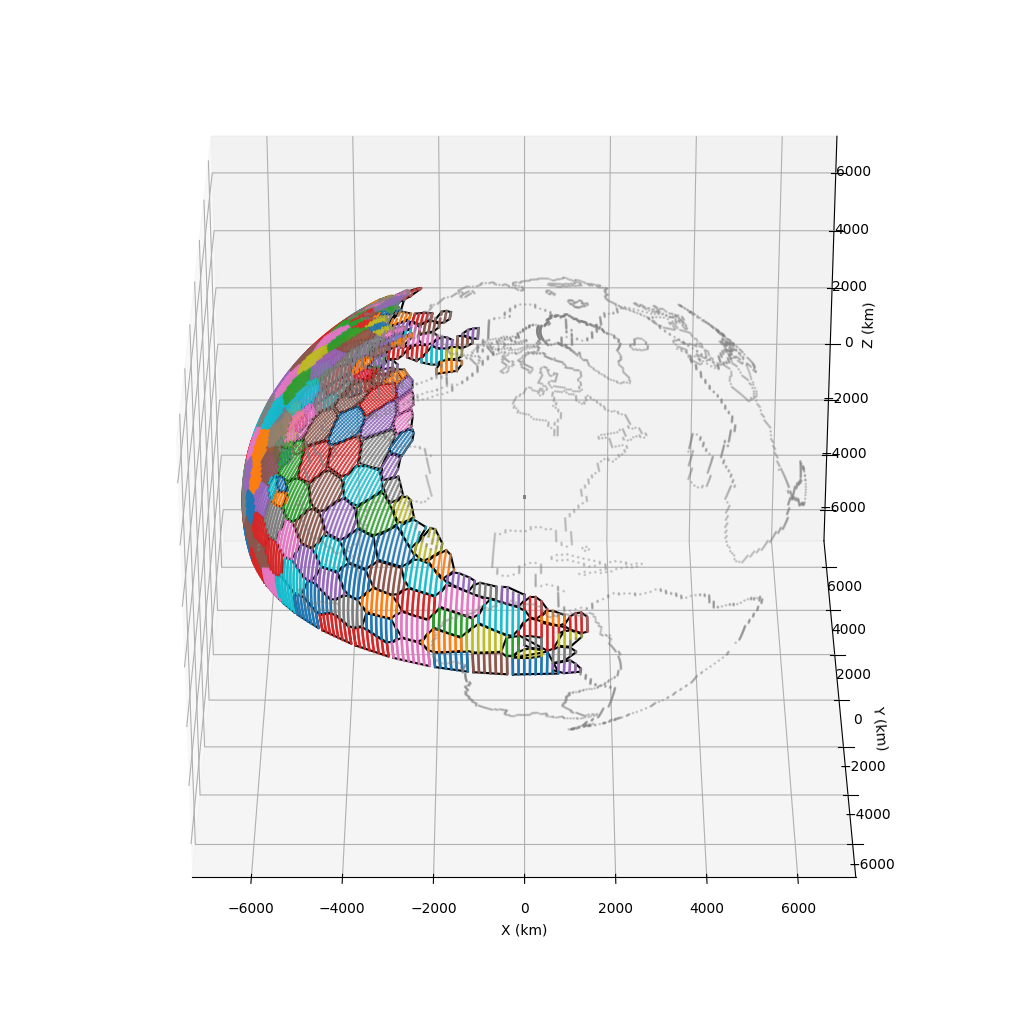

In [146]:
plot_3d_pattern(elev=30, azim = -90, atl=False, pac=True, save=False, close =False)

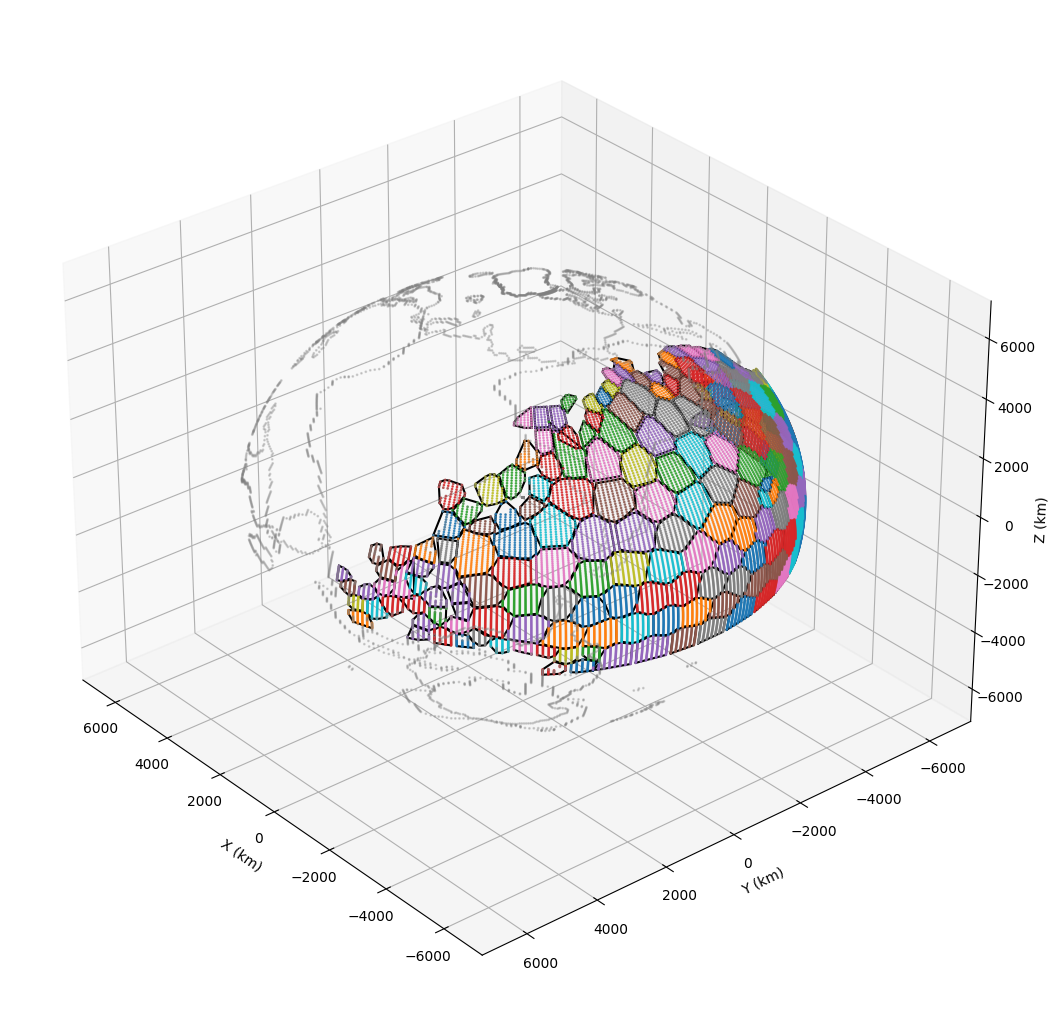

In [148]:
plot_3d_pattern(elev=30, azim = -220, atl=False, pac=True, save=False, close =False)

In [157]:
az

array([ -30,  -32,  -34,  -36,  -38,  -40,  -42,  -44,  -46,  -48,  -50,
        -52,  -54,  -56,  -58,  -60,  -62,  -64,  -66,  -68,  -70,  -72,
        -74,  -76,  -78,  -80,  -82,  -84,  -86,  -88,  -90,  -92,  -94,
        -96,  -98, -100, -102, -104, -106, -108, -110, -112, -114, -116,
       -118, -120, -122, -124, -126, -128, -130, -132, -134, -136, -138,
       -140, -142, -144, -146, -148, -150, -152, -154, -156, -158, -160,
       -162, -164, -166, -168, -170, -172, -174, -176, -178, -180, -182,
       -184, -186, -188, -190, -192, -194, -196, -198, -200, -202, -204,
       -206, -208, -210, -212, -214, -216, -218])

CPU times: user 3.85 s, sys: 23.9 ms, total: 3.88 s
Wall time: 3.96 s


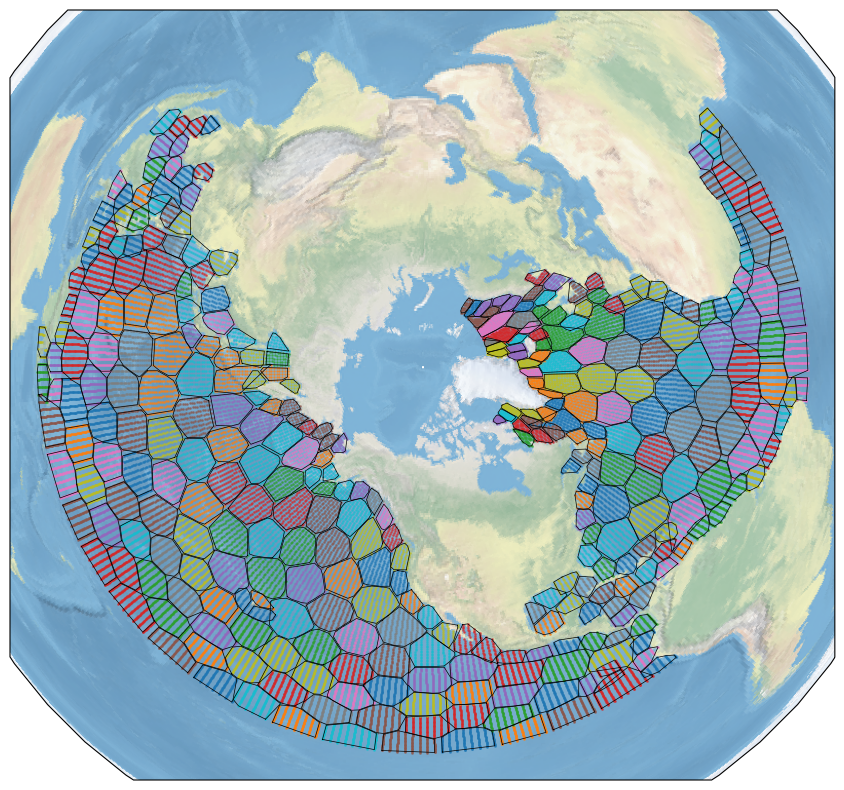

In [16]:
%%time
fig = plt.figure(figsize=(18,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.LambertAzimuthalEqualArea(central_longitude=240, central_latitude=90))
ax.set_extent([95, 390, -20, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(final_polygon_mask_atlantic)):
    vertices = np.array(final_polygon_vertices_atlantic[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())
    
for i in range(len(final_polygon_mask)):
    vertices = np.array(final_polygon_vertices[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    #ax.text(cluster_centers[i, 0]-2, cluster_centers[i, 1]-1,str(i+1), fontsize=9, color='k', transform=ccrs.PlateCarree())


#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

# ax.set_xticks(np.arange(100, 390, 20), crs=ccrs.PlateCarree())
# ax.set_yticks(np.arange(-10, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter) 

ax.tick_params(axis='both', which='major', labelsize=12)

#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/Forcing_pattern_together.png', dpi=400, bbox_inches='tight')

CPU times: user 9.94 s, sys: 740 ms, total: 10.7 s
Wall time: 10.9 s


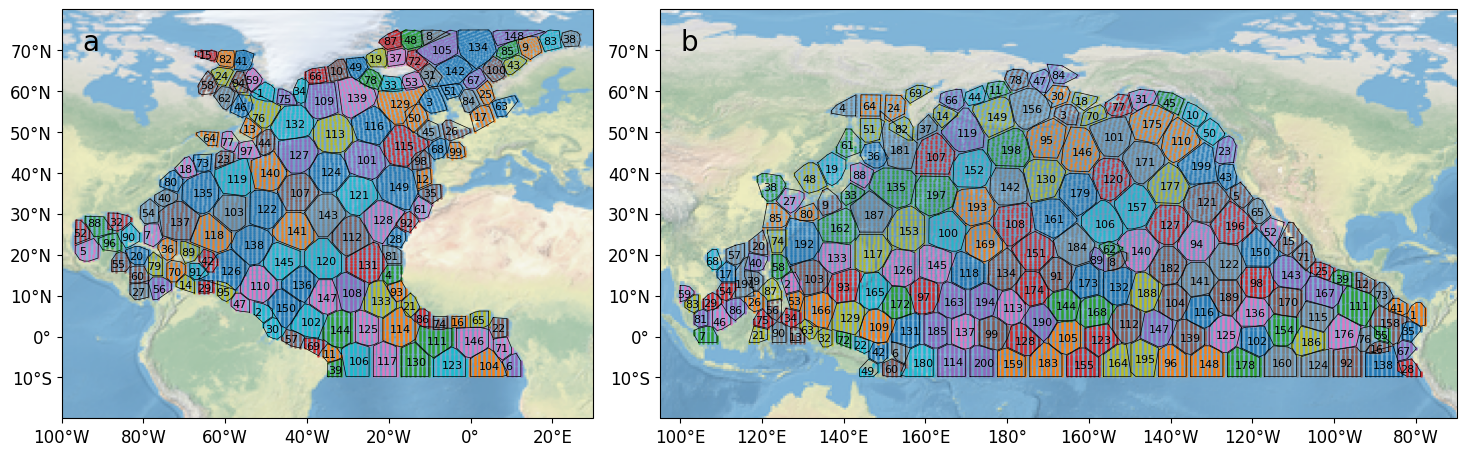

In [70]:
%%time
fig = plt.figure(figsize=(18, 10))
gs = gridspec.GridSpec(1, 2, width_ratios=[130, 195])  # Adjust the width ratios as needed

# Create the first subplot on the left
ax = plt.subplot(gs[0], projection=ccrs.PlateCarree())
ax.set_extent([-100, 30, -20, 80], crs=ccrs.PlateCarree())
ax.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(final_polygon_mask_atlantic)):
    vertices = np.array(final_polygon_vertices_atlantic[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask_atlantic[i] == 1)
    ax.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    ax.text(cluster_centers_atlantic[i, 0]-2, cluster_centers_atlantic[i, 1]-1,str(i+1), fontsize=8, color='k', transform=ccrs.PlateCarree())

#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

ax.set_xticks(np.arange(-100, 30, 20), crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-10, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)  
ax.tick_params(axis='both', which='major', labelsize=12)

ax.text(-95, 70, 'a', fontsize=20)

#################################

ax1 = plt.subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
ax1.set_extent([95,290, -20, 80], crs=ccrs.PlateCarree())
ax1.stock_img()

# a list of colors
colors = list(mcolors.TABLEAU_COLORS.values())
ind_color = np.arange(len(colors)) # 0- 9

for i in range(len(final_polygon_mask)):
    vertices = np.array(final_polygon_vertices[i])
    # plot convex hull
    if len(vertices) >= 3:
        hull = ConvexHull(vertices) # get the indices of the periphery of a patch, for plotting purpose
        polygon = list(vertices[i] for i in hull.vertices.tolist() )
        polygon = np.array(polygon)

        ax1.plot(np.append(polygon[:,0], polygon[0,0]), np.append(polygon[:,1], polygon[0,1]), 'k-', linewidth=0.5, transform=ccrs.PlateCarree())
    
    # plot polygon masks
    index = np.where(final_polygon_mask[i] == 1)
    ax1.scatter(tlong[index], tlat[index], c=colors[random.choice(ind_color)], s=1, alpha=0.6, transform=ccrs.PlateCarree())
    ax1.text(cluster_centers[i, 0]-2, cluster_centers[i, 1]-1,str(i+1), fontsize=8, color='k', transform=ccrs.PlateCarree())

#ax.set_title('Pacific EEZ n=90, Open ocean n=110', fontsize=20)

ax1.set_xticks(np.arange(100, 290, 20), crs=ccrs.PlateCarree())
ax1.set_yticks(np.arange(-10, 80, 10), crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax1.xaxis.set_major_formatter(lon_formatter)
ax1.yaxis.set_major_formatter(lat_formatter) 
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.text(-80, 70, 'b', fontsize=20)

plt.subplots_adjust(wspace=0.1, hspace=0.3)

#plt.savefig(f'/glade/work/mengyangz/GVP/Manuscript/Forcing_pattern_seperated.png', dpi=400, bbox_inches='tight')